Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


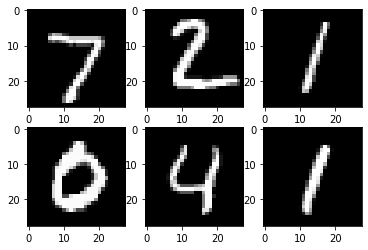

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784 # 28x28
hidden_size = 500
hidden_size2 = 200
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001
num_nn = 10

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Linear(hidden_size, hidden_size2) 
        self.l3 = nn.Linear(hidden_size2, num_classes)  
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        # no activation and no softmax at the end
        return out



In [2]:

models = []
criterions = []
optimizers = []
for x in range(num_nn):
  models.append(NeuralNet(input_size, hidden_size, num_classes).to(device))
  criterions.append(nn.CrossEntropyLoss())
  optimizers.append(torch.optim.Adam(models[x].parameters(), lr=learning_rate+(x/float(num_nn))*(0.0025-learning_rate)))
  n_total_steps = len(train_loader)
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = models[x](images)
        loss = criterions[x](outputs, labels)
        
        # Backward and optimize
        optimizers[x].zero_grad()
        loss.backward()
        optimizers[x].step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}' + "   nn number:" + str(x))


# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = models[0](images)/10.0
        for x in range(num_nn-1):
          outputs += models[x+1](images)/10.0
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the networks on the 10000 test images: {acc} %')

Epoch [1/2], Step [100/600], Loss: 0.4328   nn number:0
Epoch [1/2], Step [200/600], Loss: 0.2369   nn number:0
Epoch [1/2], Step [300/600], Loss: 0.2136   nn number:0
Epoch [1/2], Step [400/600], Loss: 0.1396   nn number:0
Epoch [1/2], Step [500/600], Loss: 0.2129   nn number:0
Epoch [1/2], Step [600/600], Loss: 0.1523   nn number:0
Epoch [2/2], Step [100/600], Loss: 0.0922   nn number:0
Epoch [2/2], Step [200/600], Loss: 0.0499   nn number:0
Epoch [2/2], Step [300/600], Loss: 0.2518   nn number:0
Epoch [2/2], Step [400/600], Loss: 0.0456   nn number:0
Epoch [2/2], Step [500/600], Loss: 0.1659   nn number:0
Epoch [2/2], Step [600/600], Loss: 0.0685   nn number:0
Epoch [1/2], Step [100/600], Loss: 0.4185   nn number:1
Epoch [1/2], Step [200/600], Loss: 0.2423   nn number:1
Epoch [1/2], Step [300/600], Loss: 0.1586   nn number:1
Epoch [1/2], Step [400/600], Loss: 0.0941   nn number:1
Epoch [1/2], Step [500/600], Loss: 0.0911   nn number:1
Epoch [1/2], Step [600/600], Loss: 0.0783   nn n

In [3]:
#experimental model.
model1 = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)  

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images1 = images.reshape(-1, 28*28).to(device)
        labels1 = labels.to(device)
        
        # Forward pass
        outputs1 = model1(images1)
        loss1 = criterion1(outputs1, labels1)
        
        # Backward and optimize
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss1.item():.4f}')

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model1(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Epoch [1/2], Step [100/600], Loss: 0.3895
Epoch [1/2], Step [200/600], Loss: 0.1809
Epoch [1/2], Step [300/600], Loss: 0.2421
Epoch [1/2], Step [400/600], Loss: 0.2131
Epoch [1/2], Step [500/600], Loss: 0.1103
Epoch [1/2], Step [600/600], Loss: 0.1056
Epoch [2/2], Step [100/600], Loss: 0.1174
Epoch [2/2], Step [200/600], Loss: 0.0648
Epoch [2/2], Step [300/600], Loss: 0.0792
Epoch [2/2], Step [400/600], Loss: 0.0851
Epoch [2/2], Step [500/600], Loss: 0.0743
Epoch [2/2], Step [600/600], Loss: 0.0694
Accuracy of the network on the 10000 test images: 97.33 %
